# VAE Attempt

In [1]:
import os
import matplotlib.image as pltim
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Rescaling

2023-03-10 02:08:29.791286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 02:08:29.962538: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-10 02:08:29.984887: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 02:08:29.984897: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
# Params

BATCH_SIZE = 32
INPUT_SHAPE = (448, 448, 3)
EPOCHS = 4000
LATENT_DIMS = 800

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

In [4]:
X_train = image_dataset_from_directory(
    '../raw_data/abstract_art_512/', 
    labels=None, # Changed from label_mode -> labels
    image_size=INPUT_SHAPE[:2], 
    batch_size=BATCH_SIZE,
    crop_to_aspect_ratio=True,
    shuffle=False
)

Found 8145 files belonging to 1 classes.


2023-03-10 02:08:31.866434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-10 02:08:31.866450: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-10 02:08:31.866461: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lscr): /proc/driver/nvidia/version does not exist
2023-03-10 02:08:31.873284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
##ds = ds.map(lambda x: x/255)
##ds = ds.map(lambda x: (x, x))

In [6]:
im = Image.open('../raw_data/abstract_art_512/abstract_abdul-qader-al-raes_258.jpg')
im.mode

'RGB'

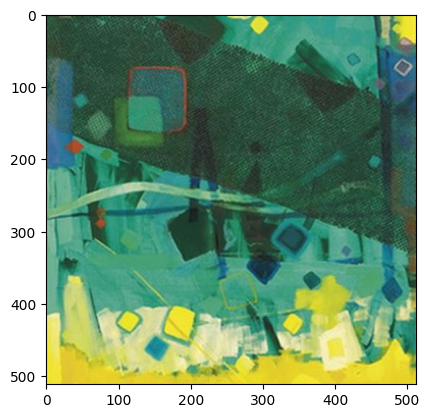

In [7]:
im = pltim.imread('../raw_data/abstract_art_512/abstract_abdul-qader-al-raes_258.jpg')
plt.imshow(im)

In [8]:
imgs = X_train.as_numpy_iterator().__next__()

In [9]:
imgs.shape

(32, 448, 448, 3)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU

X_train=imgs/255

def build_encoder(latent_dimension):
    encoder = Sequential()
    
    encoder.add(Rescaling(scale=1./255, input_shape=(448, 448, 3))) # Added this layer
    encoder.add(Conv2D(32, (3, 3), padding='same', activation='relu')) #, input_shape=(448, 448, 3)))
    # encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))

    encoder.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    # encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))

    encoder.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    # encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))
    
    encoder.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    # encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension, activation='tanh'))
    
    return encoder

In [11]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
def build_decoder(latent_dimension):
    decoder = Sequential()
    decoder.add(Dense(7*7*64, activation='tanh', input_shape=(latent_dimension,)))
    decoder.add(Reshape((7, 7, 64)))
    decoder.add(Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu'))
    # decoder.add(UpSampling2D((2, 2)))
    decoder.add(Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid'))
    return decoder

In [12]:
encoder = build_encoder(latent_dimension=LATENT_DIMS)

In [13]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 448, 448, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 448, 448, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 224, 224, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     7

In [14]:
decoder = build_decoder(latent_dimension=LATENT_DIMS)

In [15]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3136)              2511936   
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      73856     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 56, 56, 32)       18464     
 ranspose)                                                       
                                                      

In [16]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input


def build_autoencoder(encoder, decoder):
    inp = Input(INPUT_SHAPE)
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

autoencoder = build_autoencoder(encoder, decoder)

In [17]:
from tensorflow.keras.optimizers import Adam

autoencoder.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001)
)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

autoencoder.fit(
    X_train, X_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=[es], 
    verbose=1
)

Epoch 1/4000
1/1 [==============================] - 3s 3s/step - loss: 0.0037
Epoch 2/4000
1/1 [==============================] - 2s 2s/step - loss: 0.0039
Epoch 3/4000
1/1 [==============================] - 2s 2s/step - loss: 0.0042
Epoch 4/4000
1/1 [==============================] - 2s 2s/step - loss: 0.0041
Epoch 5/4000
1/1 [==============================] - 2s 2s/step - loss: 0.0039
Epoch 6/4000
1/1 [==============================] - 2s 2s/step - loss: 0.0039
Epoch 7/4000
1/1 [==============================] - 2s 2s/step - loss: 0.0040
Epoch 8/4000
1/1 [==============================] - 2s 2s/step - loss: 0.0039
Epoch 9/4000
1/1 [==============================] - 2s 2s/step - loss: 0.0039
Epoch 10/4000
1/1 [==============================] - 2s 2s/step - loss: 0.0038
Epoch 11/4000
1/1 [==============================] - 2s 2s/step - loss: 0.0038
Epoch 12/4000
1/1 [==============================] - 2s 2s/step - loss: 0.0039
Epoch 13/4000
1/1 [==============================] - 2s 2s/st

In [19]:
prediction = autoencoder.predict(X_train, verbose=0, batch_size=BATCH_SIZE)# you can now display an image to see it is reconstructed well

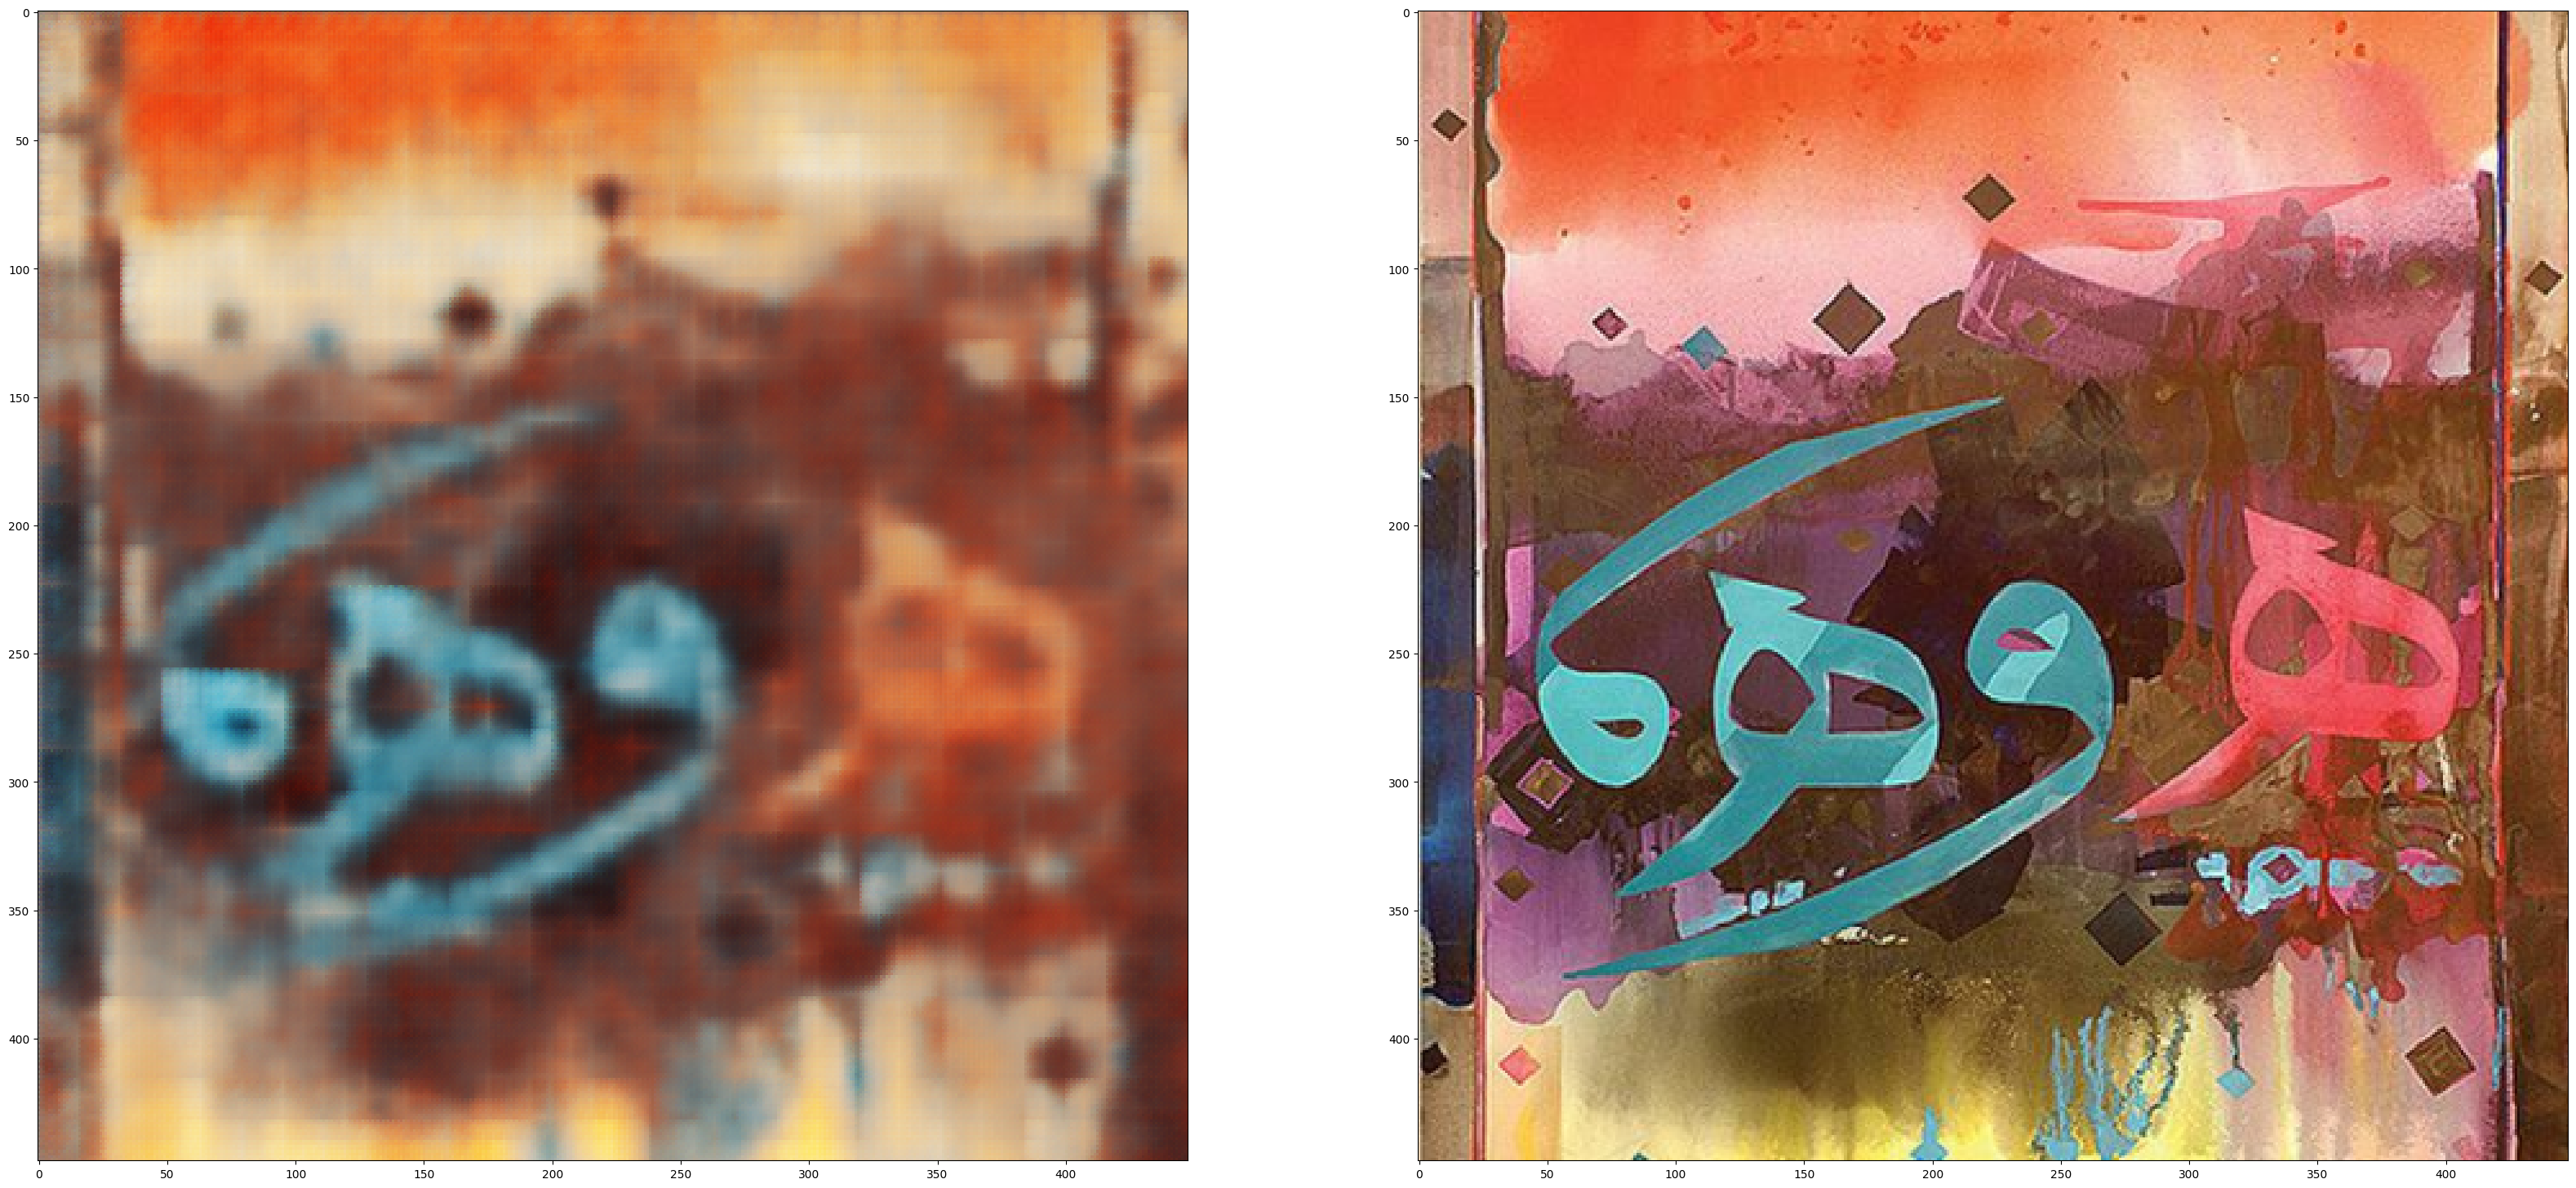

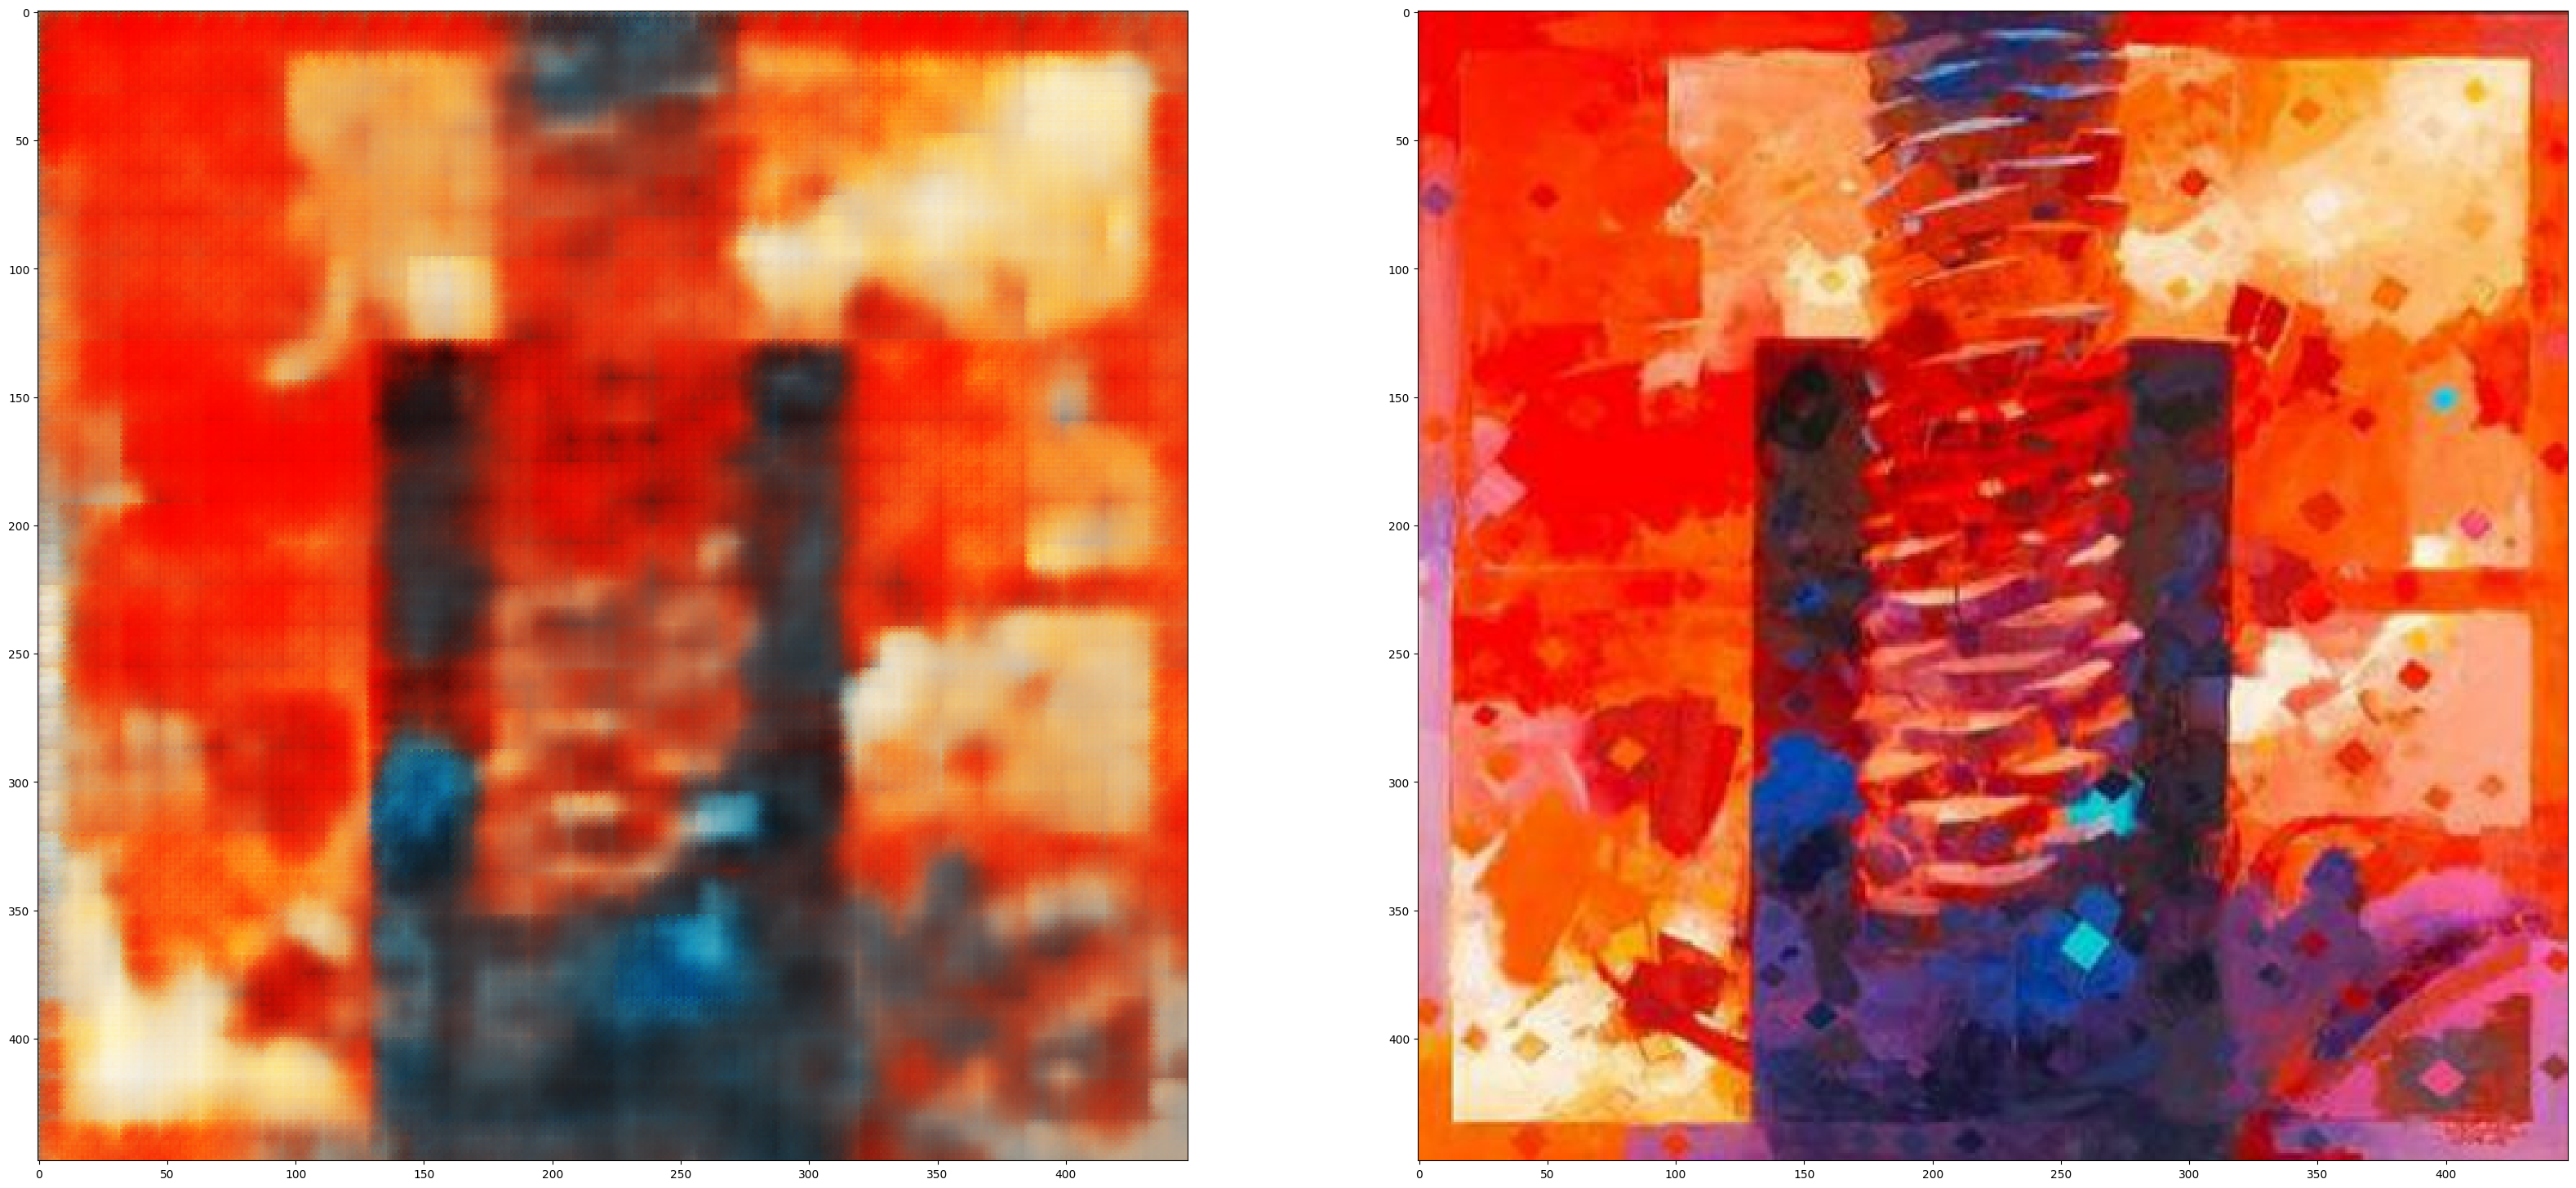

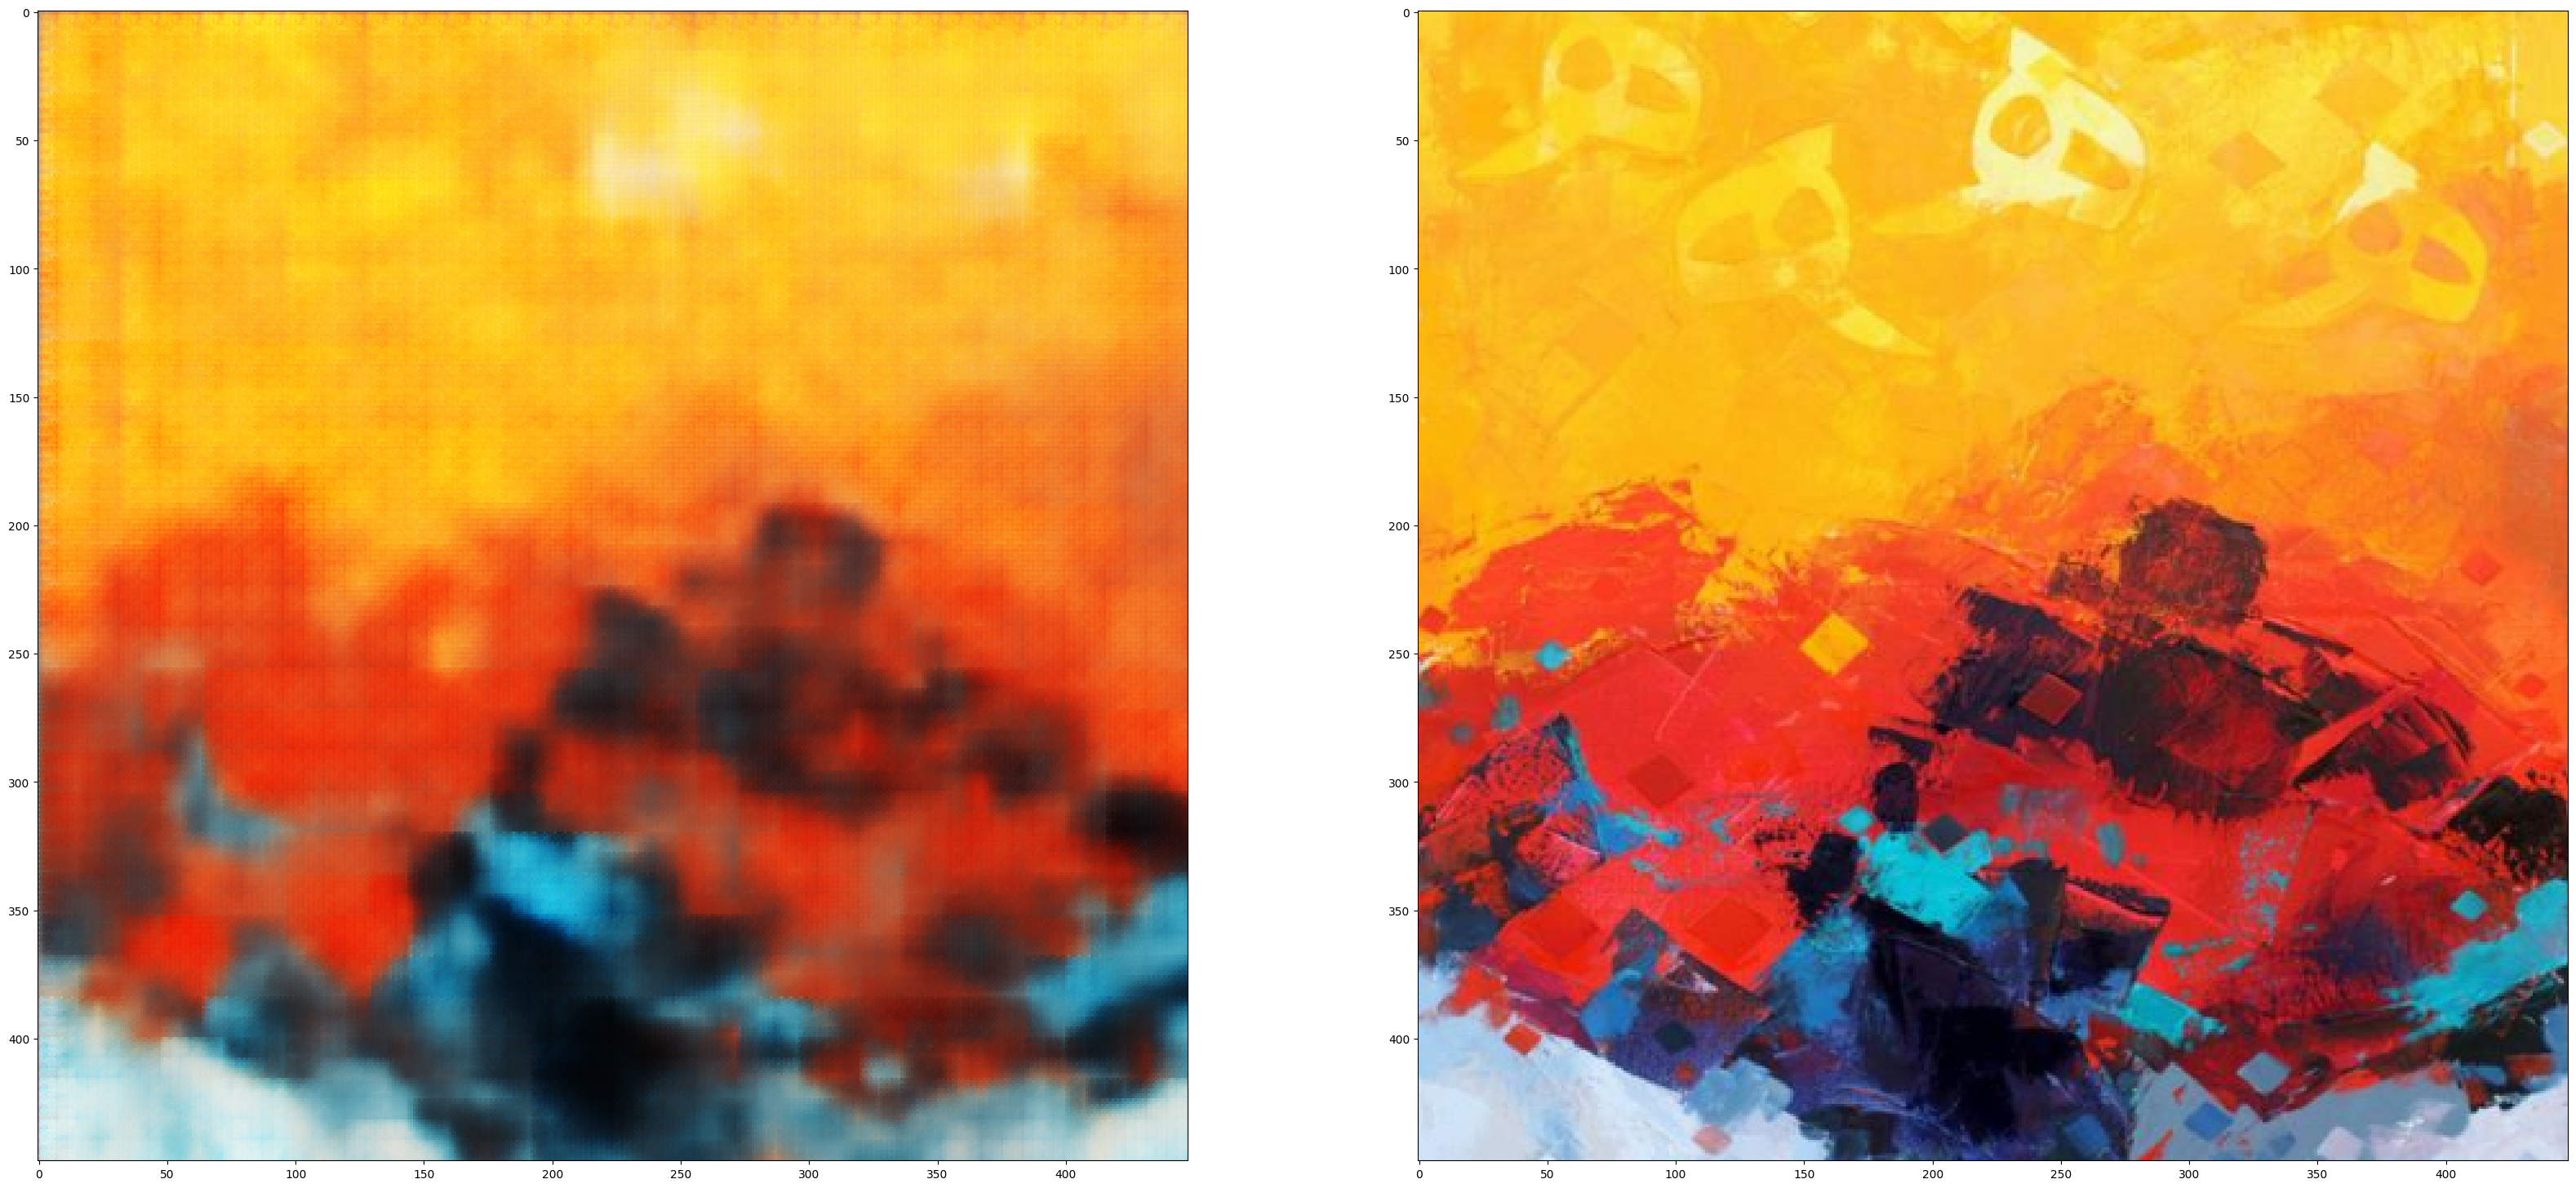

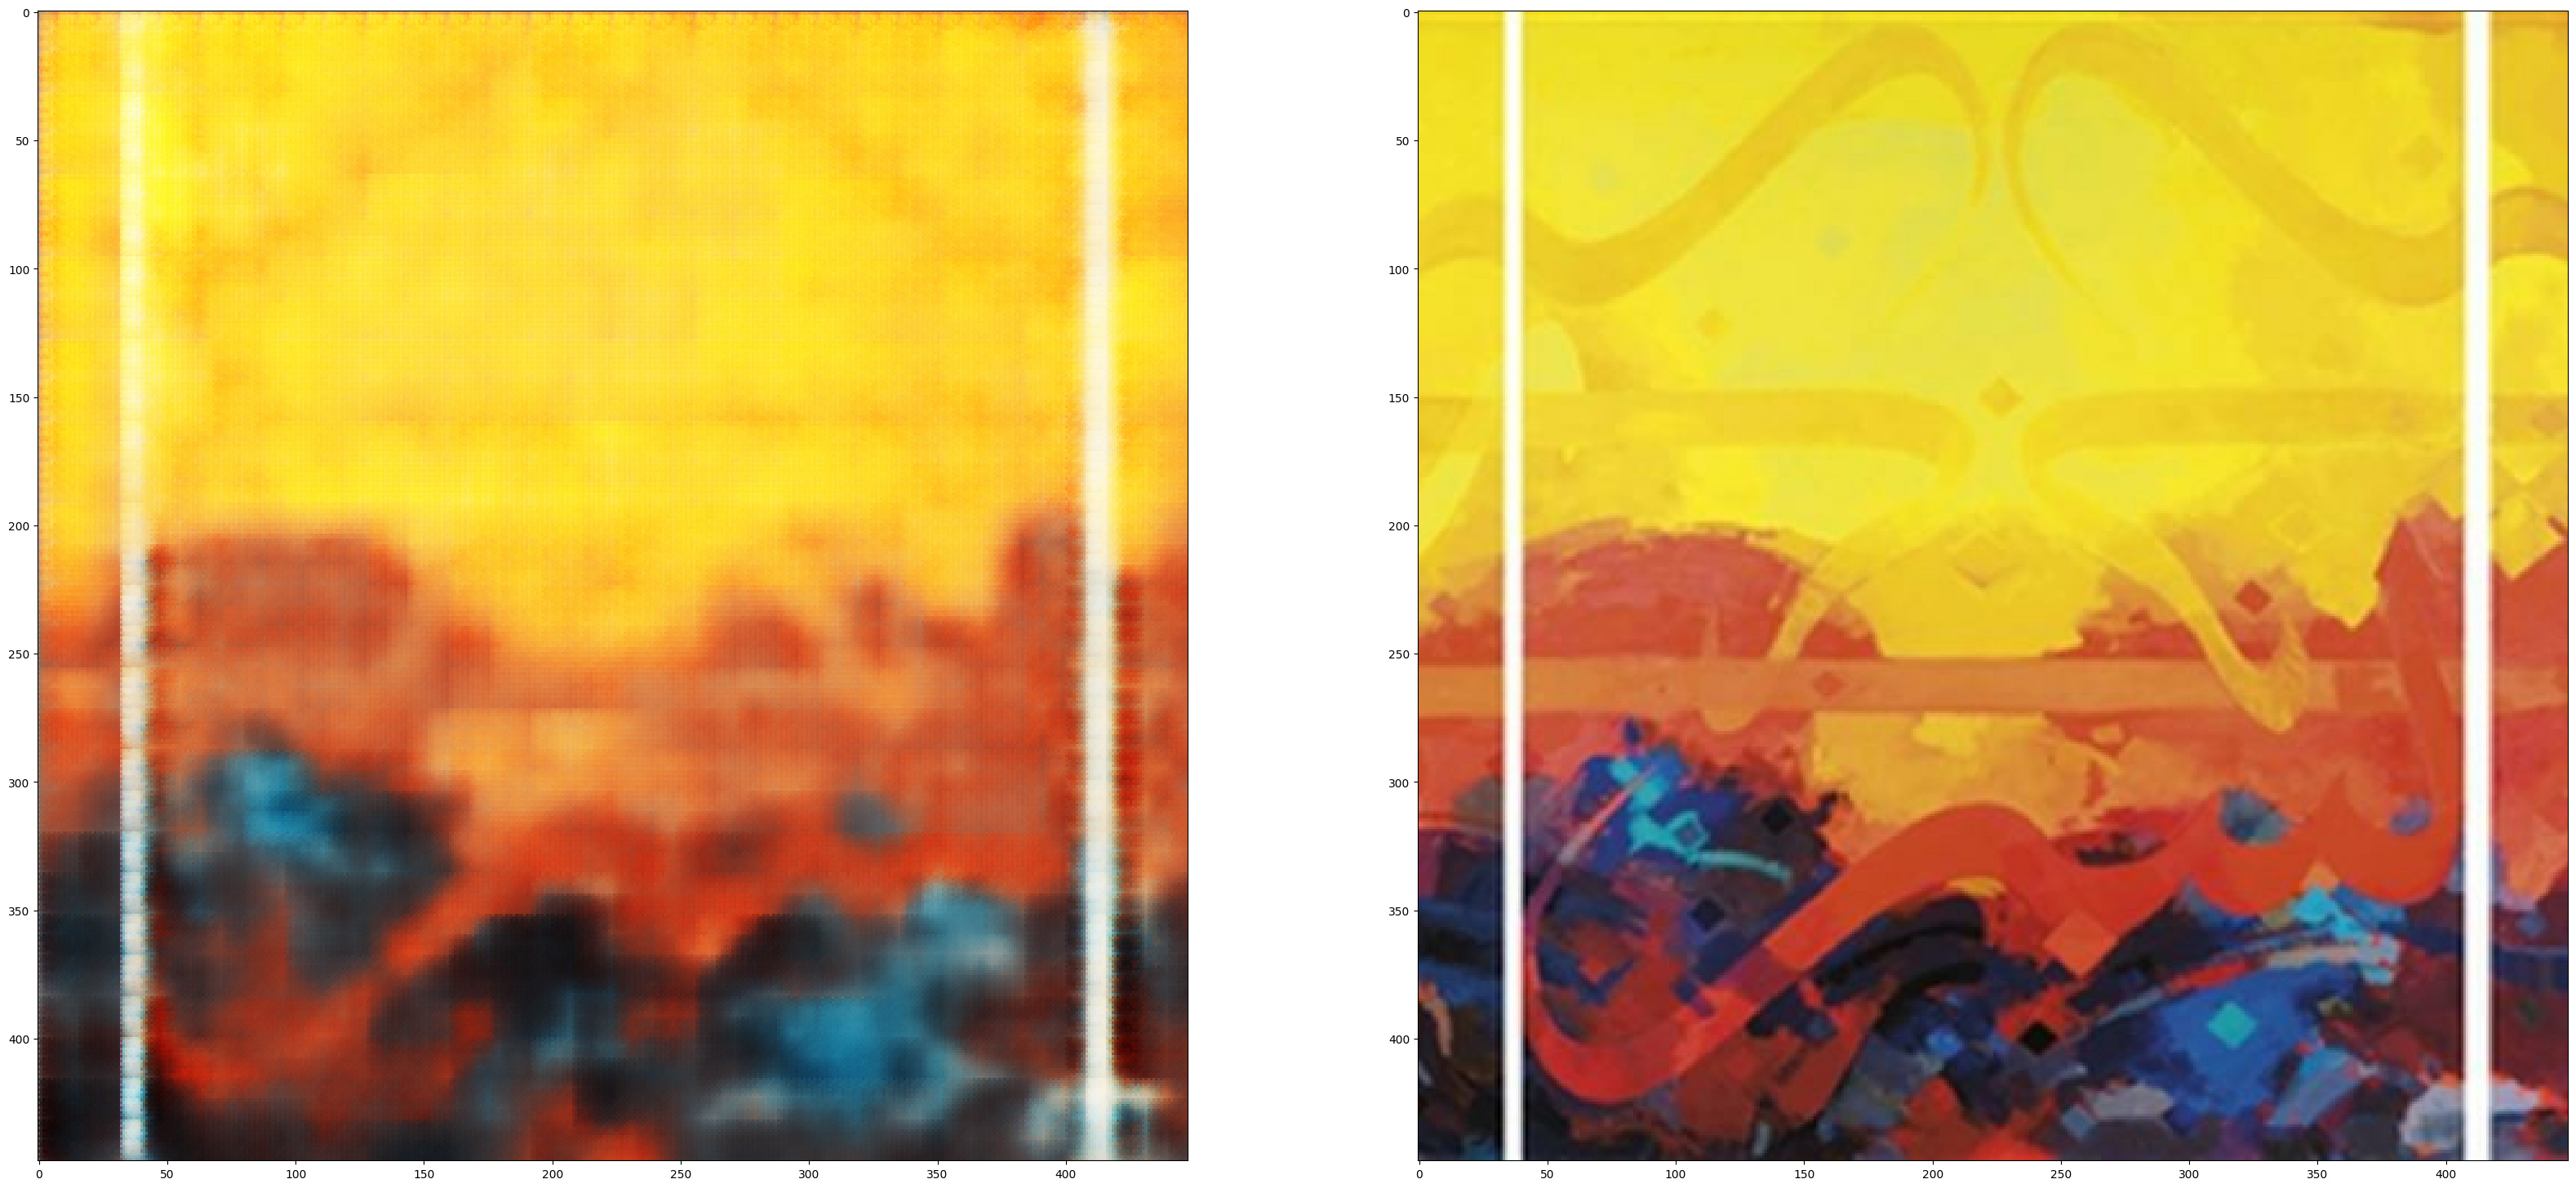

In [26]:
for i in range(3, 7):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    ax1.imshow((prediction[i] * 255).astype(np.uint8))
    ax2.imshow(X_train[i].reshape(448, 448, 3))
    plt.show()

In [21]:
#autoencoder.save('autoencoder-latent-dim-800.h5')

In [25]:
X_train.shape

(32, 448, 448, 3)

In [27]:
# The latent space vectors for the first two images

encoded_pred = encoder.predict(X_train[3:5])

1/1 [==============================] - 0s 133ms/step


In [29]:
encoded_pred.shape

(2, 800)

In [30]:
start_lat_vec, end_lat_vec = encoded_pred[0], encoded_pred[1]

In [32]:
start_lat_vec.shape, end_lat_vec.shape

((800,), (800,))

In [36]:
N_STEPS = 100

step_vec = (end_lat_vec - start_lat_vec ) / N_STEPS

In [39]:
interpolation_images = []

for i in range(0, N_STEPS):
    interpolation_images.append(start_lat_vec + (i * step_vec))
    
interp_array = np.array(interpolation_images)

In [40]:
interp_array.shape

(100, 800)

In [42]:
inter_images = decoder.predict(interp_array)
inter_images = (inter_images * 255).astype('uint8')

4/4 [==============================] - 0s 40ms/step


In [43]:
inter_images.shape

(100, 448, 448, 3)

In [44]:
for i in range(inter_images.shape[0]):
    im = Image.fromarray(inter_images[i])
    im.save(f'../raw_data/abstract_art_test/image_{i}.jpg')

In [ ]:
def make_gif(frame_folder):
    im_paths = [f'{frame_folder}/image_{i}.jpg' for i in range(100)]
    frames = [Image.open(image) for image in im_paths]
    
    frame_one = frames[0]
    frame_one.save(
        'abstract_art_test2.gif', 
        format='GIF', 
        append_images=frames, 
        save_all=True,
        duration=100,
        loop=0
    )